In [1]:
from transformer_lens import HookedTransformer

fruit_string = " Apple -> Red | Banana -> Yellow | Blueberry -> Blue | Grape -> Purple | Lime -> Green | Strawberry -> Red | Lemon -> Yellow | Blackberry -> Black | Raspberry -> Red | Plum ->"
non_fruit_string = " Plum ->"
new_fruit_string = " Corn ->"

model = HookedTransformer.from_pretrained("gemma-2b", device="mps")


/Users/sudarshanagopalkunnavakkam/Documents/Github/pair stuff/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Loaded pretrained model gemma-2b into HookedTransformer


blocks.0.hook_resid_post torch.Size([39, 2048])
blocks.1.hook_resid_post torch.Size([39, 2048])
blocks.2.hook_resid_post torch.Size([39, 2048])
blocks.3.hook_resid_post torch.Size([39, 2048])
blocks.4.hook_resid_post torch.Size([39, 2048])
blocks.5.hook_resid_post torch.Size([39, 2048])
blocks.6.hook_resid_post torch.Size([39, 2048])
blocks.7.hook_resid_post torch.Size([39, 2048])
blocks.8.hook_resid_post torch.Size([39, 2048])
blocks.9.hook_resid_post torch.Size([39, 2048])
blocks.10.hook_resid_post torch.Size([39, 2048])
blocks.11.hook_resid_post torch.Size([39, 2048])
blocks.12.hook_resid_post torch.Size([39, 2048])
blocks.13.hook_resid_post torch.Size([39, 2048])
blocks.14.hook_resid_post torch.Size([39, 2048])
blocks.15.hook_resid_post torch.Size([39, 2048])
blocks.16.hook_resid_post torch.Size([39, 2048])
blocks.17.hook_resid_post torch.Size([39, 2048])


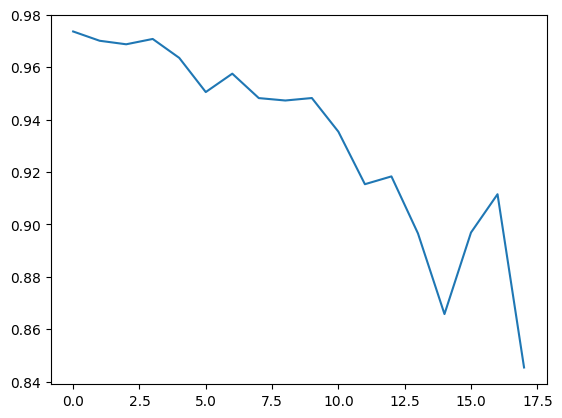

In [2]:
import torch
import matplotlib.pyplot as plt

fruit_logits, fruit_activations = model.run_with_cache(fruit_string, remove_batch_dim=True)
non_fruit_logits, non_fruit_activations = model.run_with_cache(non_fruit_string, remove_batch_dim=True)

arr = []
for key, value in list(fruit_activations.items())[2:]:
    if "resid_post" not in key:
        continue
    print(key, value.shape)

    fruit_activations_normed = fruit_activations[key][-1]
    fruit_activations_normed = fruit_activations_normed / torch.norm(fruit_activations_normed)

    non_fruit_activations_normed = non_fruit_activations[key][-1]
    non_fruit_activations_normed = non_fruit_activations_normed / torch.norm(non_fruit_activations_normed)

    arr.append(torch.dot(fruit_activations_normed, non_fruit_activations_normed).cpu())

plt.plot(arr)
plt.show()

In [15]:
# we want to first tokenize the new_fruit_string and fruit_string
new_fruit_string_tokens = model.tokenizer(new_fruit_string, return_tensors="pt")
fruit_string_tokens = model.tokenizer(fruit_string, return_tensors="pt")
non_fruit_string_tokens = model.tokenizer(non_fruit_string, return_tensors="pt")

layer_num = 13

task_vector = fruit_activations[f"blocks.{layer_num}.hook_resid_pre"][-1]
task_vector

def hook(resid_post, hook):
    if resid_post.shape[1] == 1:
        return
    
    patching_position = len(non_fruit_string_tokens["input_ids"]) - 1
    task_token_position = len(fruit_string_tokens["input_ids"]) - 1

    print(resid_post.shape)

    resid_post[:, patching_position, :] = task_vector

def hooked_generate(prompt, fwd_hooks=[], **kwargs):
    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt)
        result = model.generate(
            stop_at_eos=True,
            input=tokenized,
            max_new_tokens=5, 
            do_sample=True,
            **kwargs
        )
    return result

sampling_kwargs = sampling_kwargs = dict(temperature=0.0, top_p=0.1, freq_penalty=1.0)


In [13]:
def run_generate(example_prompt):
    model.reset_hooks()
    editing_hooks = [(f"blocks.{layer_num}.hook_resid_pre", hook)]
    res = hooked_generate(example_prompt, fwd_hooks=editing_hooks)

    res_str = model.to_string(res)
    print(res_str)

In [16]:
run_generate(new_fruit_string)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1, 3, 2048])


100%|██████████| 5/5 [03:20<00:00, 40.13s/it]

['<bos> Corn -> Corn -> Corn -> Corn']


In [ ]:
# we do one-shot behavior cloning as a "rephraser"

from typing import List

normal_sentences = [
    "Could you please pass me the salt?",
    "I didn't expect it to rain today.",
    "Can we reschedule the meeting to next week?",
    "It seems like there was a misunderstanding.",
    "I think we need to reconsider our approach."
]

furious_sentences = [
    "Pass me the damn salt right now!",
    "How the hell is it raining today?!",
    "We absolutely must reschedule the meeting to next week, no exceptions!",
    "This misunderstanding is completely unacceptable and infuriating!",
    "We have to change our approach immediately, this is ridiculous!"
]

# now we should make two strings: an ICL string and a counterfactual string
# "->" is a single token for Gemma

icl_string = ""
counterfactual_string = ""
for normal, furious in zip(normal_sentences[:-2], furious_sentences[:-2]):
    icl_string += normal + " ->" + furious + "\n"
    counterfactual_string += normal + " ->" + normal + "\n"

icl_string += normal_sentences[-2] + " ->"
counterfactual_string += normal_sentences[-2] + " ->"

print(icl_string)
print(counterfactual_string)



Could you please pass me the salt? ->Pass me the damn salt right now!
I didn't expect it to rain today. ->How the hell is it raining today?!
Can we reschedule the meeting to next week? ->We absolutely must reschedule the meeting to next week, no exceptions!
It seems like there was a misunderstanding. ->
Could you please pass me the salt? ->Could you please pass me the salt?
I didn't expect it to rain today. ->I didn't expect it to rain today.
Can we reschedule the meeting to next week? ->Can we reschedule the meeting to next week?
It seems like there was a misunderstanding. ->


In [ ]:
import transformer_lens

model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

icl_logits, icl_activations = model.run_with_cache(icl_string)
counterfactual_logits, counterfactual_activations = model.run_with_cache(counterfactual_string)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
print(icl_activations)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re